## Collaborative Filtering(CF)
- 전처리 과정

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
print(df.shape) #원본 데이터 900만개를 사용

(9073128, 10)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


## LabelEncoder
- user/beer 컬럼은 지금은 non-sequential integer이다. 그러므로 unique ID를 나타내는 것으로 value를 바꿔주어야 한다.
- 이 때 이용하는 것이 바로 'labelencoder()' 
- 이를 이용하면 모델링을 위해, 변수의 value를 0부터 시작되는 숫자로 바꿀 수 있다. (숫자->숫자도 되고 문자->숫자도 된다.)

In [5]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
uid = df['userid'].values
df['user'] = user_enc.fit_transform(uid.tolist()) #array 인식이 안돼서 list로 빼냄.(userid의 경우만 오류 발생)
n_users = df['user'].nunique()

In [6]:
item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [7]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [8]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [9]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
beers = pd.read_csv('beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [11]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

# Recommdation System using Keras 
- 각 유저와 각 맥주를 나타내기 위해 'embedding'이라는 것을 활용한다.->(설명부분 캡처)
- 'embeddings'는 벡터이다(n_factor 사이즈의). 시작은 랜덤한 숫자로 가고, 각 유저/맥주의 필수적인 특징을 잡으면 fit model을 해보자.
- fit model 과정) 유저 벡터와 맥주 벡터를 스칼라곱(dot product)하여 예측 평점을 계산함.
- 이를 위해선 유니크한 유저 수와 맥주 수가 필요, -> 각각의 embedding matrix의 사이즈를 정의하기 위함.

In [29]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

- 기본

In [30]:
#원래 함수(수정): 텐서플로우 backend를 사용하고 있어서 그냥 keras로는 못돌린다.
##bias가 있음, 아주 단순한 버전. 그냥 R_hat = u*m으로 연산한다.

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) #initializer는 정규분포
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV1(n_users, n_beers, n_factors):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산
    x = Dot(axes=1)([u, b]) #예측행렬 R_hat은 u*m을 한 것.
    x = Add()([x, ub, bb])

    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001) #learning rate(학습률) 설정. #optimizer인 최적화 방법은 Adam을 씀.
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) #loss와 함께 출력할 mae, mse는 metrics로 설정.

    return model

In [31]:
re1model = RecommenderV1(n_users, n_beers, n_factors)
re1model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        8246750     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        15477100    input_8[0][0]                    
____________________________________________________________________________________________

In [16]:
## fit model
import numpy as np
seed = 7
np.random.seed(seed)
history_mf = re1model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 1784s 246us/step - loss: 0.4587 - mae: 0.4242 - mse: 0.4587 - val_loss: 0.4385 - val_mae: 0.4098 - val_mse: 0.4385
Epoch 2/10
7258502/7258502 [==============================] - 1720s 237us/step - loss: 0.2967 - mae: 0.3585 - mse: 0.2967 - val_loss: 0.3648 - val_mae: 0.3796 - val_mse: 0.3648
Epoch 3/10
7258502/7258502 [==============================] - 1721s 237us/step - loss: 0.2300 - mae: 0.3251 - mse: 0.2300 - val_loss: 0.3327 - val_mae: 0.3655 - val_mse: 0.3327
Epoch 4/10
7258502/7258502 [==============================] - 1718s 237us/step - loss: 0.1883 - mae: 0.2995 - mse: 0.1883 - val_loss: 0.3184 - val_mae: 0.3604 - val_mse: 0.3184
Epoch 5/10
7258502/7258502 [==============================] - 1723s 237us/step - loss: 0.1576 - mae: 0.2779 - mse: 0.1576 - val_loss: 0.3133 - val_mae: 0.3599 - val_mse: 0.3133
Epoch 6/10
7258502/7258502 [==============================] -

In [17]:
## show loss & mae & mse at each epoch
hist1 = pd.DataFrame(history_mf.history)
hist1['epoch'] = history_mf.epoch
hist1

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.438504,0.409844,0.438504,0.458720,0.424196,0.458721,0
1,0.364751,0.379584,0.364751,0.296729,0.358543,0.296729,1
2,0.332728,0.365529,0.332728,0.230042,0.325127,0.230042,2
3,0.318414,0.360356,0.318414,0.188310,0.299462,0.188310,3
4,0.313291,0.359933,0.313291,0.157605,0.277923,0.157605,4
5,0.312663,0.361640,0.312663,0.134694,0.260359,0.134694,5
6,0.313825,0.363531,0.313825,0.117679,0.246217,0.117679,6
7,0.316089,0.365990,0.316089,0.105396,0.235023,0.105396,7
8,0.319021,0.368493,0.319021,0.096643,0.226338,0.096643,8
9,0.321343,0.370528,0.321343,0.090384,0.219753,0.090384,9


In [18]:
#모델 평가하기; model.evaluate() #test set에 평가했을 때, 맨 마지막 epoch의 val_loss, val_mae, val_mse
loss_and_metrics = re1model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 4s 2us/step
## evaluation loss and_metrics ##
[0.3213433812464461, 0.3705280125141144, 0.32134339213371277]


In [19]:
## get weights of the beers embedding matrix
beer_embedding_weights = re1model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [20]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [21]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 79%로, 어느정도 성능이 좋다!

array([0.7891224 , 0.02582216, 0.01150525], dtype=float32)

# 신경망에서 과적합 방지하기 위해 사용하는 방법
정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방법은 다음과 같습니다:
- 더 많은 훈련 데이터를 모읍니다.
- 네트워크의 용량을 줄입니다.(output의 reshape)
- 가중치 규제를 추가합니다.(L1 or L2)
- 드롭아웃을 추가합니다.(dropout)

- train-error와 test-error의 꺾은선이 차이나는 epoch: 과적합이 발생하는 부분.
- 과적합을 막기 위해, '규제'와 'dropout'을 사용해야 한다!(교수님 의견)

- 과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것입니다. 즉, 모델에 있는 학습 가능한 파라미터의 수를 줄입니다(모델 파라미터는 층(layer)의 개수와 층의 유닛(unit) 개수에 의해 결정됩니다). 딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 "용량"이라고 말합니다. 직관적으로 생각해 보면 많은 파라미터를 가진 모델이 더 많은 "기억 용량"을 가집니다. 이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학습할 수 있습니다. 하지만 이전에 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것입니다.
- 항상 기억해야 할 점은 딥러닝 모델이 훈련 세트에는 학습이 잘 되는 경향이 있지만 진짜 해결할 문제는 학습이 아니라 일반화라는 것입니다.
- 알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋습니다.
- 출처: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

### 번외, 임베딩에 규제

In [22]:
############번외. embedding에 규제를 넣으면 값이 달라질까?############

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.001))(x) #initializer는 정규분포
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV1withL2(n_users, n_beers, n_factors):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산
    x = Dot(axes=1)([u, b]) #예측행렬 R_hat은 u*m을 한 것.
    x = Add()([x, ub, bb])

    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model = Model(inputs=[user, beer], outputs=x)
    opt = Adam(lr=0.001) #learning rate(학습률) 설정. #optimizer인 최적화 방법은 Adam을 씀.
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) #loss와 함께 출력할 mae, mse는 metrics로 설정.

    return model

In [23]:
r1w_model = RecommenderV1withL2(n_users, n_beers, n_factors)
r1w_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        8246750     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        15477100    input_4[0][0]                    
____________________________________________________________________________________________

In [24]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = r1w_model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 2700s 372us/step - loss: 12.4701 - mae: 3.2033 - mse: 10.8385 - val_loss: 12.0689 - val_mae: 3.0257 - val_mse: 9.7982
Epoch 2/10
7258502/7258502 [==============================] - 2583s 356us/step - loss: 12.0653 - mae: 3.0218 - mse: 9.7794 - val_loss: 12.0688 - val_mae: 3.0216 - val_mse: 9.7795
Epoch 3/10
7258502/7258502 [==============================] - 2556s 352us/step - loss: 12.0653 - mae: 3.0211 - mse: 9.7762 - val_loss: 12.0688 - val_mae: 3.0220 - val_mse: 9.7818
Epoch 4/10
7258502/7258502 [==============================] - 2569s 354us/step - loss: 12.0652 - mae: 3.0212 - mse: 9.7767 - val_loss: 12.0687 - val_mae: 3.0218 - val_mse: 9.7807
Epoch 5/10
7258502/7258502 [==============================] - 2572s 354us/step - loss: 12.0652 - mae: 3.0212 - mse: 9.7766 - val_loss: 12.0691 - val_mae: 3.0217 - val_mse: 9.7802
Epoch 6/10
7258502/7258502 [======================

In [25]:
## show loss & mae & mse at each epoch
hist2 = pd.DataFrame(history_mf.history)
hist2['epoch'] = history_mf.epoch
hist2

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,12.068924,3.025654,9.798208,12.470068,3.203260,10.838488,0
1,12.068759,3.021598,9.779487,12.065284,3.021756,9.779351,1
2,12.068781,3.022007,9.781841,12.065263,3.021097,9.776199,2
3,12.068671,3.021840,9.780702,12.065245,3.021174,9.776686,3
4,12.069053,3.021722,9.780156,12.065249,3.021168,9.776626,4
5,12.068745,3.021715,9.780901,12.065229,3.021140,9.776358,5
6,12.068814,3.021807,9.779712,12.065225,3.021131,9.776676,6
7,12.068816,3.021855,9.780489,12.065298,3.021142,9.776426,7
8,12.068771,3.022341,9.782336,12.065212,3.021055,9.776169,8
9,12.068649,3.021864,9.780375,12.065299,3.021239,9.776881,9


In [26]:
#모델 평가하기; model.evaluate()
loss_and_metrics = r1w_model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 62s 34us/step
## evaluation loss and_metrics ##
[12.068648863152866, 3.0218636989593506, 9.780375480651855]


In [27]:
## get weights of the beers embedding matrix
beer_embedding_weights = r1w_model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [28]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [29]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 4%로, 규제를 하면 pca 성능이 낮아짐을 알 수 있다. 원본 모델을 사용하는 편이 좋은 듯!

array([0.04063141, 0.03656046, 0.03531476], dtype=float32)

### 시각화

In [43]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


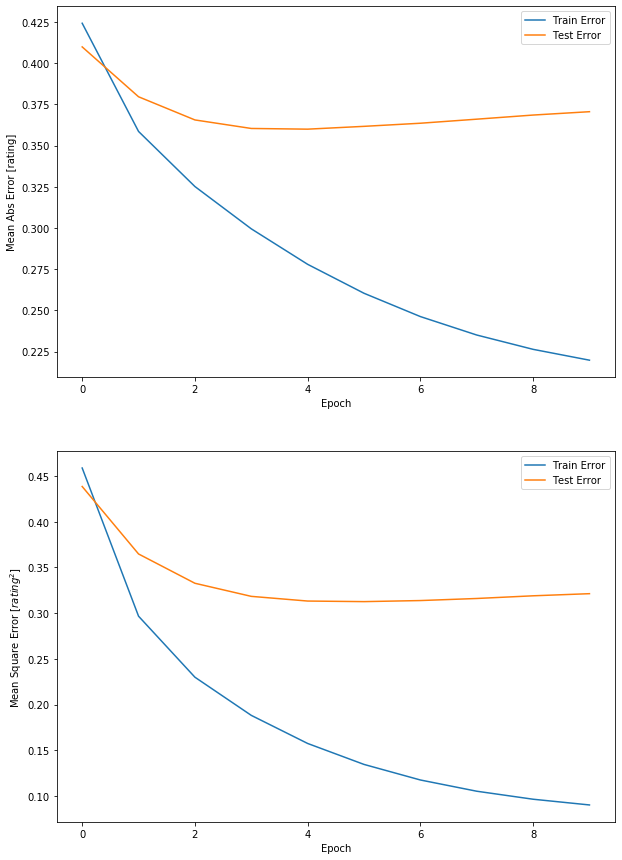

In [35]:
plot_history(hist1)

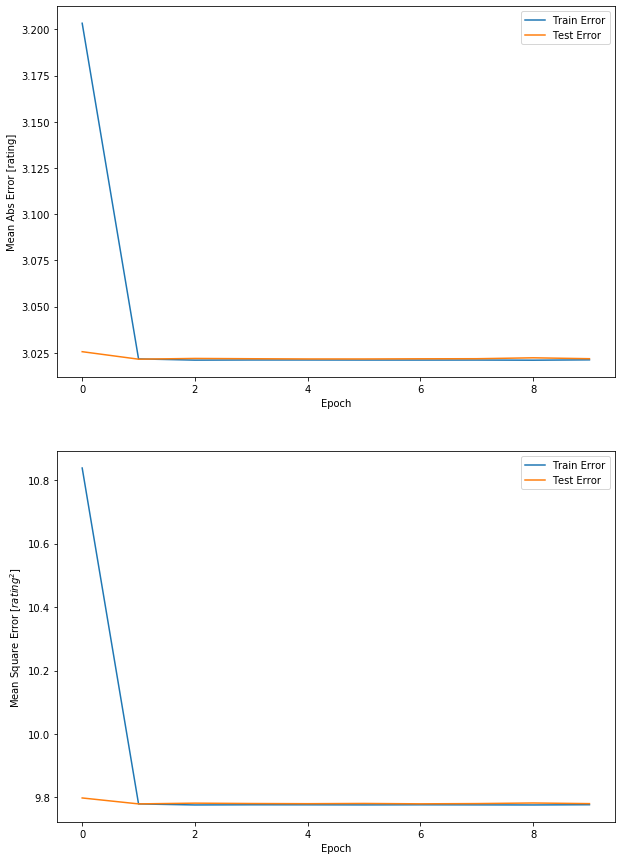

In [36]:
plot_history(hist2)